---
title: "Baby's N-Gram Model"
author: "Matt Allen"
date: "2024-05-09"
categories: [ai, language model]
image: "MLP.png"

format:
    html:
        code-fold: true
        code-summary: "Show the code"
jupyter: python
---

## [Code and data for this post](https://github.com/mattheweallen/special-memory/tree/main/babys_first_language_model)

## Motivation

The main reason I created this blog post was to build my understanding of Language Models by actually getting my hands dirty and coding as well as explaining the concepts in my own words. This post is based on the first three lectures in the series [Neural Networks: Zero to Hero](https://karpathy.ai/zero-to-hero.html). Emulating the masters can be a good way to get good at painting as well as AI.

Different people start their AI learning journey with different strengths. My background is in Software and Statistics and I feel the Neural Networks: Zero to Hero is a good blend of hardcore software and the math behind it, which I appreciated.

Some may come with a strength in Coding. [Practical Deep Learning for Coders](https://course.fast.ai/) is a great resource to get started as well.

An application of the N-Gram and MLP models we will build could be a predictive text model on say a cell phone keyboard.

Our application will be generating new names. This is not necessarily useful, but is a step in understanding how to train LLMs. It also satisfies my intellectual curiosity to understand how Language Models work under the hood.

## Introduction

This piece is an introduction to language models by way of the paper [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). The paper develops a Multilayer Perceptron (MLP) with learned distributed feature vectors for each word. Nowadays the distributed feature vectors are called embeddings. Embeddings are a solution to the curse of dimensionality i.e. the model will be able to group similar concepts in a vector space to generalize better. As the paper states, it fights the curse of dimensionality with its own weapons. The training sentences inform the model about a combinatorial number of other sentences. In the context of this post, the training sentences are baby names from the Social Security Administration.

Before developing MLPs, we will create a Bigram language model that existed before MLPs. The Bigram model is a special case of [n-gram language models](https://en.wikipedia.org/wiki/Word_n-gram_language_model). An n-gram model uses n-1 tokens to predict the next token. It is a Statistical language model that uses counts of the previous character combinations to predict the next token. 

We will then go on to create an MLP. 

The MLP architecture was replaced by Recurrent Neural Networks which were replaced by LSTMs which were replaced by Transformers. However, the language modeling framework developed in this paper is still used today. Furthermore, MLP layers are alternated between attention layers in the Transformer architecture of modern LLMs. Also, the fundamentals of tokenization, embeddings, hyperparameters and training loops remain. MLPs are a good place to start in language modeling, because they are easier to understand than transformers and are still trainable with smaller compute.

We will be able to use these models as Generative AI to create new name like words.

## Data

The data are first names registered with the Social Security Administration (SSA) from the year of birth 1880 to 2022. Each row contains a name, gender and number of SSA registrations with that name. Here is an example row:

Stephanie,F,22775

A zip file was downloaded that contains data across years 1880 to 2022. Each file contains one year. All the  files across those years were read and the name was pulled out of the row and changed to be all lowercase without distinguishing between gender, year or popularity. Here is an example row after data wrangling from the file yob1991.txt to be used in the models:

stephanie

All the unique names across all the years were combined into a single file called names_1880_To_2022.txt, so that the data wrangling step just needs to be done once and then the data can be read from the file.

In [2]:
import os
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
from fastbook import *

generator_seed = 12623637008

# this step does the data wrangling.
# get the data into a reusable format
# use the output file of this step to build examples for the model

# set wrangle_data to True if you haven't created names_1880_To_2022.txt yet.
# the data was downloaded and unzip from https://www.ssa.gov/OACT/babynames/names.zip
# the names folder is at the same level in the file system as this notebook.
wrangle_data = False

# https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
def get_filepaths(directory):
    """
    This function will generate the file names in a directory 
    tree by walking the tree either top-down or bottom-up. For each 
    directory in the tree rooted at directory top (including top itself), 
    it yields a 3-tuple (dirpath, dirnames, filenames).
    """
    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.

    return file_paths  # Self-explanatory.


if(wrangle_data):
    # Run the above function and store its results in a variable. 
    # Get all the files paths in the names folder.  
    full_file_paths = get_filepaths("names")
    # number of files
    number_of_files = len(full_file_paths)

    # put all the names into an array. make them all lowercase
    all_names = []

    for f in full_file_paths:
        if f.endswith(".txt"):
            names_split = open(f).read().splitlines()
            all_names.extend([line.split(',')[0].lower() for line in names_split])

    # collect some stats on the data
    number_of_names = len(all_names)
    unique_names = list(set(all_names))
    number_of_unique_names = len(unique_names)

    # save the unique names to a file
    with open('names_1880_To_2022.txt', 'w') as f:
        f.write('\n'.join(unique_names))

Let's read in and look at the data. Below you can see that the shortest names are two letters and the longest are 15.

In [3]:
ssa_names = open('names_1880_To_2022.txt').read().splitlines()

total_number_names = len(ssa_names)
print("total number of names:", total_number_names)

min_len_word = min(len(w) for w in ssa_names)
max_len_word = max(len(w) for w in ssa_names)
print("min length word:", min_len_word, "max length word:", max_len_word)

shortest_names = [w for w in ssa_names if len(w) <= min_len_word]
longest_names = [w for w in ssa_names if len(w) >= max_len_word]
print("shortest_names:", shortest_names)
print("longest_names:", longest_names)

#random.seed(generator_seed) # uncomment if you want the names to always be the same.
print("random sample of 5 names: ", random.choices(ssa_names, k=5))

total number of names: 102449
min length word: 2 max length word: 15
shortest_names: ['ii', 'ja', 'vi', 'od', 'kd', 'ax', 'jd', 'jp', 'st', 'sa', 'rc', 'jt', 'xi', 'ju', 'zy', 'mi', 'kj', 'cj', 'ho', 'se', 'io', 'ge', 'eh', 'jw', 'un', 'kc', 'no', 'an', 'mr', 'va', 'oz', 'du', 'ji', 'ah', 'tr', 'mc', 'si', 'zi', 'ld', 'go', 'pj', 'la', 'qi', 'jm', 'or', 'bj', 'sy', 'lu', 'ao', 'zo', 'su', 'ed', 'xu', 'za', 'ra', 'bb', 'na', 'ry', 'ki', 'pa', 'gy', 'md', 'vu', 'fu', 'ti', 'lj', 'jo', 'ad', 'ej', 'di', 'jl', 'my', 'ku', 'mu', 'lc', 'vy', 'te', 'ar', 'aj', 'ze', 'rb', 'ly', 'jc', 'el', 'so', 'ya', 'ma', 'gi', 'ia', 'yu', 'po', 'li', 'ac', 'lb', 'sj', 'tu', 'ke', 'fe', 'ro', 'kt', 'dj', 'al', 'eb', 'wa', 'mj', 'ab', 'oh', 'rj', 'tc', 'je', 'hy', 'lg', 'yi', 'om', 'yy', 'oc', 'ty', 'me', 'ko', 'av', 'ny', 'ng', 'yo', 'ai', 'jb', 'ka', 'jj', 'ru', 'ea', 'ni', 'ky', 'da', 'rd', 'de', 'le', 'bo', 'do', 'ta', 'rl', 'jr', 'ye', 'in', 'mo', 'ok', 'wc', 'hu', 'wm', 'ha', 'bg', 'ba', 'be', 'lo', 'c

After reading the data from the file, we tokenize the data. Tokenization is a subject in itself. We will create a very simple tokenizer. The tokenizer creates a vocabulary of 26 lower case letters of the alphabet plus a '.'. The '.' is used as a special character used to mark the beginning and end of names.

We build the tokenizer vocabulary by concatenating all the names together with no spaces and then create an ordered list of unique characters. This ends up covering all 26 lowercase letters in the English alphabet. We add the '.' character to this list.

We create two mappings. One that encodes the characters to numbers and one that decodes numbers to characters. We need to convert the words to numbers, because that is the language of computers. We convert numbers back to characters, so that English speaking humans can understand it.

In [4]:
# tokenizer: the tokens are '.' + lowercase alphabet
tokens = ['.'] + sorted(list(set((''.join(ssa_names)))))
print("tokens:", tokens)

# token to int converter
stoi = {s:i for i,s in enumerate(tokens)} # string to int
print("stoi:", stoi)
# int to token converter
itos = {i:s for s,i in stoi.items()} # int to string
print("itos:", itos)

tokens: ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi: {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


Finally, we create a function that will build the inputs and outputs that we will feed to the models. The inputs and outputs are created with names that have been shuffled and split into Training, Development and Test sets. The training set is used to train our model by updating its weights. We use the development/validation set to tune hyperparameters. Finally, we use the Test set sparingly. Ideally it is used only once. The performance of the model is based on the Test set. That is the number we would report in our paper and show off to our friends and family.

The concept is that we want the model to perform well on unseen data. If we were to use Training set metrics to report the performance of our model, our model could simply memorize the training data to get the possible performance, but it would not do well on new data. Everytime we use a set of data to calculate model performance, the model is learning something from it and it starts to fit to it, but again we want to evaluate our models on data that it has not seen.

We could wind up in the scenario that the Test Set performance is not good. Unfortunately, that means we may have to start over. It is not a good situation, but it is better to know.

The function also takes a block_size value. This parameter determines the size of the context. That is the number of characters of input we use to predict the next character. In a Bigram model for example, the block_size is 1.

Each name in the training data contains several examples. For example with a block_size of 3, the name matt contains five examples and the name kathy contains six examples:

In [5]:
# block size is the context length
def build_dataset(words, block_size = 1, verbose = False): 
    X, Y = [], []
    
    ndex = 0
    num_examples_to_print = 2

    for w in words:
        if verbose and ndex < num_examples_to_print:
            print(w)
            print("input ---> output")
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if verbose and ndex < num_examples_to_print:
                # pretty print first three names
                print(''.join(itos[i] for i in context), '--->', itos[ix])
                
            context = context[1:] + [ix] # crop and append

        ndex = ndex + 1

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [6]:
build_dataset(['matt', 'kathy'], block_size = 3, verbose = True)

matt
input ---> output
... ---> m
..m ---> a
.ma ---> t
mat ---> t
att ---> .
kathy
input ---> output
... ---> k
..k ---> a
.ka ---> t
kat ---> h
ath ---> y
thy ---> .


(tensor([[ 0,  0,  0],
         [ 0,  0, 13],
         [ 0, 13,  1],
         [13,  1, 20],
         [ 1, 20, 20],
         [ 0,  0,  0],
         [ 0,  0, 11],
         [ 0, 11,  1],
         [11,  1, 20],
         [ 1, 20,  8],
         [20,  8, 25]]),
 tensor([13,  1, 20, 20,  0, 11,  1, 20,  8, 25,  0]))

## Bigram model (Special case of N-Gram)

The bigram model uses one character of context to predict the next character. The simplest construction of this model is to count frequencies of two characters occurring one after the other. We can use these frequencies to create an n-gram model, which is a probability distribution to predict the next character. It is the probability distribution of the next character conditioned on previous characters. In the case of a Bigram, there is only one previous character to condition on.

The equation below taken from [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) describes the N-Gram model. In the case of our character level bigram model, the probability distribution below that we are trying to model says the probability of the w sub t (w is word, but think character in our case) conditioned on the words (or characters) before it is approximately the probability of w sub t on the previous n-1 characters. The characters nearest the next character have the most influence.

### Statistical Language Model Equation from [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

![Statistical Language Model](StatisticalLangModelEquation.png)

To build our Bigram model, we create a table of counts of two letter combinations and count all those combinations in the data. Let's look at the data through a visual of the counts for every two character combination. The underlying tensor will be used to build the bigram model.

First we split the data into training, development/validation and test sets and then use the build_dataset function created earlier to get the inputs and outputs. Our dataset split is 80% training, 10% development/validation and 10% test.

In [8]:
# shuffle the words and then get the training splits
random.shuffle(ssa_names) # mix the words up
n1 = int(0.8*len(ssa_names)) # cut off point for training set
n2 = int(0.9*len(ssa_names)) # cut off for dev set

# build bigram dataset. note second dimension of x is 1. this is the context length (block_size)
words_tr = ssa_names[:n1]
Xtr, Ytr = build_dataset(words_tr, verbose=True) # training set used to update model parameters
print("Xtr shape:", Xtr.shape, "Ytr shape: ", Ytr.shape)

words_dev = ssa_names[n1:n2]
Xdev, Ydev = build_dataset(words_dev, verbose=False) # development or validation set used to tune hyper parameters like embedding size or hidden layer size
print("Xdev shape:", Xdev.shape, "Ydev shape: ", Ydev.shape)

words_te = ssa_names[n2:]
Xte, Yte = build_dataset(words_te, verbose=False) # test set used once or sparingly. report the performance of the model based on this set.
print("Xte shape:", Xte.shape, "Yte shape: ", Yte.shape)

madellyne
input ---> output
. ---> m
m ---> a
a ---> d
d ---> e
e ---> l
l ---> l
l ---> y
y ---> n
n ---> e
e ---> .
hanzalah
input ---> output
. ---> h
h ---> a
a ---> n
n ---> z
z ---> a
a ---> l
l ---> a
a ---> h
h ---> .
Xtr shape: torch.Size([616753, 1]) Ytr shape:  torch.Size([616753])
Xdev shape: torch.Size([77222, 1]) Ydev shape:  torch.Size([77222])
Xte shape: torch.Size([77054, 1]) Yte shape:  torch.Size([77054])


Next we create a function that will take a training data split and generate a table of counts. For the bigram model the table dimensions are 27 X 27. The 27 possible input characters label the rows and the 27 possible output characters label the columns. The function initializes a 27 X 27 table with all zeros and then adds one to a cell everytime it finds a corresponding two letter permutation for a particular cell.

We then use this function to initialize our training set matrix.

In [9]:
# takes X and Y from Build Dataset and Creates a Counts Tensor
# counts_shape is the shape of the tensor for counts
def create_counts(X, Y, counts_shape = (27,27)):
    N = torch.zeros(counts_shape, dtype=torch.int32) # initialize tensor to 0
    for ndx in zip(X, Y):
        ndx = ndx[0].tolist() + [ndx[1].item()]
        N[tuple(ndx)] += 1

    return N

N = create_counts(Xtr, Ytr)

Now that we have our counts matrix. Let's visualize it.

Each row in the table is a fixed first letter followed by each of the letters in our vocabulary. The cell is the count of the number of times a two letter permutation occurred in the training data. For example, 'c' was followed by an 'o' 1091 times in the training data.

Higher counts make the cell more blue.

Notice that some two letter permutations never occurred in the training data like "kg" or "jf" for example.

### Bigram Counts Plot

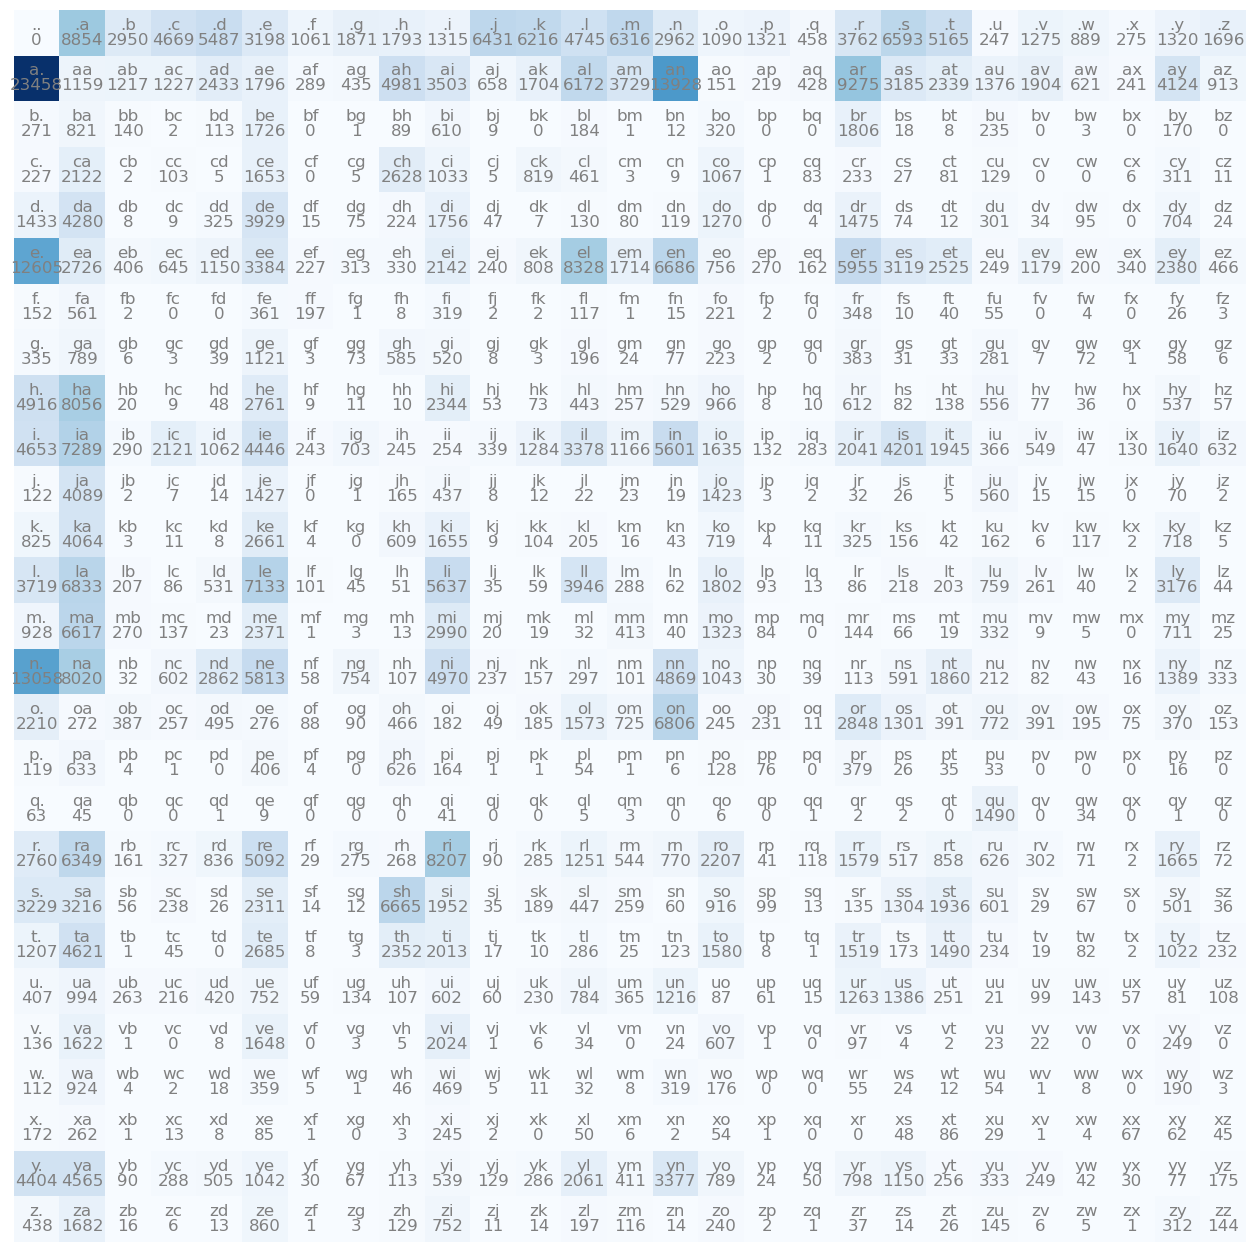

In [10]:
# visuzalize counts
# create image of N to visualize the counts of two character combinations
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j] # every 2 character combination where order matters
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis('off');

Now we normalize the counts to create a [Probability Distribution](https://en.wikipedia.org/wiki/Probability_distribution) i.e. divide all elements in the row by the sum of the row. Every value in each row is now between 0 and 1 and the values in each row summed together add to 1. Specifically each row is a [Multinomial Probability Distribution](https://en.wikipedia.org/wiki/Multinomial_distribution). This will be used to sample from each row to predict the next character in a name. 

Since some of the values are 0, we add 1 to all the cells to give everything at least some small probability of being chosen. It turns out adding a constant to each row makes the distribution smoother. In the extreme case as the constant goes to inifinity the distribution gets flat and every value in the row has equal probability. In our case for large values of the smoothing parameter, all the probabilities would be close to 1/27. You can try out different values of the smoothing parameter. You can think of it as Temperature in LLMs. As the smoothing parameter gets larger, it raises the probability of weird (unaligned) output.

We can now use this table of normalized rows to generate names. Below are names generated from the counts model.

In [11]:
# Add smoothing
# try various values
smoother =  1 #, 100, 50, 5, 110000000000000, 11

# Convert rows to 27 multinomial distributions
# Add 1 to N for smoothing. Prevents character combinations with 0 probability.
# We will be using log later, so also prevents log(0) = inf
# Also as if make constant add large the dist approaches uniform.
P = (N+smoother).float() # convert int tensor to floats for prob dist
P/= P.sum(1, keepdim=True) # normalize rows in place

# create a function to sample from the model
def bigram_generate_names(num_names, is_uniform = False):
    g = torch.Generator().manual_seed(generator_seed) # random seed for reproducibility

    p = torch.ones(27) / 27.0 # uniform case. every character has 1/27 chance of being chosen.

    for i in range(num_names):
        out = []
        ix = 0 # first letter comes from the first row
        while True:
            if(not is_uniform):
                p = P[ix] # use distribution based on the count date versus flat uniform dist

            # sample from a multinomial distribution. think generalization of coin flipping.
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            out.append(itos[ix])
            if(ix == 0): # went to special "." character which denotes end of name
                break
        print(''.join(out))

bigram_generate_names(10)

laia.
janav.
kulia.
zatelana.
ajeinlyvo.
trouso.
telicara.
ama.
ded.
shryn.


This doesn't look good. Well it depends on if you want a creative name or not. We would say the model is unaligned in Language Modeling parlance. The words are sort of name like, but are unusual. The bigram model just isn't that good, but what if we compare it to every letter having equal probability of being chosen next. This is shown below. This looks worse than the bigram model. While our bigram model is not great, we are doing better than a baseline of complete randomness.

You can also achieve a similar effect by making the smoothing constant large.

In [12]:
bigram_generate_names(10, is_uniform = True)

paiaqudnkf.
nulihdzbtxjvgacjjkijlsvogtwobkpk.
eqbivdkmamaa.
nduqucfnpzxtvvuc.
vlbyqiej.
wljuhmyvmlgueytmdighanrsaxoltuvpocvlrrqscnfltwa.
pvupuddgesbkcbzctwufmejewcvyxqzpufd.
cyggqbielkuadwcojfnhnuezrqfuskzk.
qwbemezuilfzpkiqyqqdltlwxdlwg.
gbpdlkoewopkwzubhherdhvnlipwyz.


We can observe the sample and see it does not look good, but how do we quantify if we are doing better or not. How do we evaluate the quality of the model? We need a measure of that.

We will use the average negative log likelihood. For this measure, lower numbers mean a better performing model. A function to calculate this measure for the bigram model is below.

It will take the test set of words and the probabilities derived from the training set and compute a number that represents the loss. This is how we will evaluate the quality of the model.

We find letter combinations in the test set and get the probability based on the table built from our training data. We take the log of that probability and add it to a running total. This is the total log likelihood. We also keep track of the number of letter permutations we checked. The sum of all the log likelihoods divided by the total number two letter permutations is the average log likelihood. To get the negative log likelihood, we just multiply the average log likelihood by -1.

Average Negative Log Likelihood is the same thing as [Cross Entropy](https://en.wikipedia.org/wiki/Cross-entropy). See the Estimation section in the Cross Entropy Wikipedia article. Cross Entropy is a common loss function used in language modeling.

The loss of our bigram models is

In [13]:
# how to evaluate the quality of the model? average negative log likelihood, lower is better

# GOAL: maximize likelihood of the data w.r.t. mode parameters (statistical model)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html   
def likelihood_calc(words, verbose = False, is_uniform = False):
    log_likelihood = 0
    n = 0

    for w in words:
    #for w in ["matt"]: # can evaluate probability for any word
        chs = ['.'] + list(w) + ['.'] # hallucinate special start and end token to know where word begins an ends
        for ch1, ch2 in zip(chs, chs[1:]): # cute way to get tuples of consecutive chars in word
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            prob = P[ix1, ix2] # prob that the model assigns to the bigram
            if(is_uniform):
                prob = torch.tensor(1.0/len(stoi))

            logprob = torch.log(prob)
            log_likelihood += logprob
            n += 1

            if(verbose):
                print(f'{ch1}{ch2}: prob={prob: .4f} logprob={logprob: .4f}')

    #print(f'{log_likelihood=}') # range is 0 to neg inf
    nll = -log_likelihood # negative log likelihood
    #print(f'{nll=}')
    print(f'average negative log likelihood loss={nll/n}') # average log likelihood

# evaluate loss on test set
likelihood_calc(words_te, verbose = False, is_uniform = False)

average negative log likelihood loss=2.4609196186065674


Below is the loss where the probability of every next character is 1 / 27 i.e. equally likely. Remember our vocabulary is 26 letters of the alphabet plus the '.' character to make 27 in total.

In [14]:
# compute the loss on the Test set
likelihood_calc(words_te, verbose = False, is_uniform = True)

average negative log likelihood loss=3.296685218811035


The Bigram model that uses the data is an improvement on the model that assumes every character is equally likely. The bigram model's loss is 2.47, which is less than the loss of 3.30 where the data is ignored.

## Trigram model

Does using two characters of context in a Trigram make a better model?

In [16]:
X_tri_tr, Y_tri_tr = build_dataset(words_tr, block_size=2, verbose=True) # training set used to update model parameters
X_tri_dev, Y_tri_dev = build_dataset(words_dev, block_size=2, verbose=False) # development or validation set used to tune hyper parameters like embedding size or hidden layer size
X_tri_te, Y_tri_te = build_dataset(words_te, block_size=2, verbose=False) # test set used once or sparingly. report the performance of the model based on this set.

madellyne
input ---> output
.. ---> m
.m ---> a
ma ---> d
ad ---> e
de ---> l
el ---> l
ll ---> y
ly ---> n
yn ---> e
ne ---> .
hanzalah
input ---> output
.. ---> h
.h ---> a
ha ---> n
an ---> z
nz ---> a
za ---> l
al ---> a
la ---> h
ah ---> .


In [18]:
N_trigram_tr = create_counts(X_tri_tr, Y_tri_tr, (27, 27, 27))

In [40]:
# construct P
P_tri = (N_trigram_tr+1).float() # add 1 to everything for smoothing and to prevent log(0) = inf when calculating the loss
P_tri /= P_tri.sum(2, keepdim=True)
P_tri.shape

torch.Size([27, 27, 27])

In [41]:
sum(P_tri[0,0])

tensor(1.)

In [42]:
# first generation attempt?
g = torch.Generator().manual_seed(generator_seed)

for i in range(10):

    out = []
    context = [0,0]
    while True:
        p = P_tri[tuple(context)]

        # bigram not a good model, but try just unifom dist see if better. it definitely looks worse
        # trained bigram model is not great, but gives better results than random
        #p = torch.ones(27) / 27.0

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
        context = context[1:] + [ix]

    print(''.join(out))

laia.
jana.
voulia.
zain.
ada.
ajeinlyno.
trobel.
telizarkenya.
devolucyn.
jenna.


In [43]:
def trigram_loss(words, P):

    log_likelihood = 0.0
    n = 0

    for w in words:
    #for w in ["matthew"]:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            ix3 = stoi[ch3]
            prob = P_tri[ix1, ix2, ix3]
            logprob = torch.log(prob)
            log_likelihood += logprob
            n += 1
            #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

    #print(n)
    #print(f'{log_likelihood=}')
    nll = -log_likelihood
    #print(f'{nll=}')
    #print(f'{nll/n}')
    return (nll/n).item()

In [44]:
trigram_loss(words_tr, P)

2.1379189491271973

In [45]:
trigram_loss(words_dev, P)

2.143829584121704

In [51]:
trigram_loss(words_te, P)

2.1490068435668945

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [55]:
# reinit N
N_trigram_tr = create_counts(X_tri_tr, Y_tri_tr, (27, 27, 27))

In [60]:
loss = []
smooth = []
for i in range(1,100):
    s = 0.005 * i
    P = (N_trigram_tr + s).float() # add 1 to everything for smoothing and to prevent log(0) = inf when calculating the loss
    P /= P.sum(2, keepdim=True)
    smooth.append(s)
    loss.append(trigram_loss(words_dev, P))

In [61]:
smooth

[0.005,
 0.01,
 0.015,
 0.02,
 0.025,
 0.03,
 0.035,
 0.04,
 0.045,
 0.05,
 0.055,
 0.06,
 0.065,
 0.07,
 0.075,
 0.08,
 0.085,
 0.09,
 0.095,
 0.1,
 0.105,
 0.11,
 0.115,
 0.12,
 0.125,
 0.13,
 0.135,
 0.14,
 0.145,
 0.15,
 0.155,
 0.16,
 0.165,
 0.17,
 0.17500000000000002,
 0.18,
 0.185,
 0.19,
 0.195,
 0.2,
 0.20500000000000002,
 0.21,
 0.215,
 0.22,
 0.225,
 0.23,
 0.23500000000000001,
 0.24,
 0.245,
 0.25,
 0.255,
 0.26,
 0.265,
 0.27,
 0.275,
 0.28,
 0.28500000000000003,
 0.29,
 0.295,
 0.3,
 0.305,
 0.31,
 0.315,
 0.32,
 0.325,
 0.33,
 0.335,
 0.34,
 0.34500000000000003,
 0.35000000000000003,
 0.355,
 0.36,
 0.365,
 0.37,
 0.375,
 0.38,
 0.385,
 0.39,
 0.395,
 0.4,
 0.405,
 0.41000000000000003,
 0.41500000000000004,
 0.42,
 0.425,
 0.43,
 0.435,
 0.44,
 0.445,
 0.45,
 0.455,
 0.46,
 0.465,
 0.47000000000000003,
 0.47500000000000003,
 0.48,
 0.485,
 0.49,
 0.495]

In [58]:
loss

[2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,
 2.143829584121704,


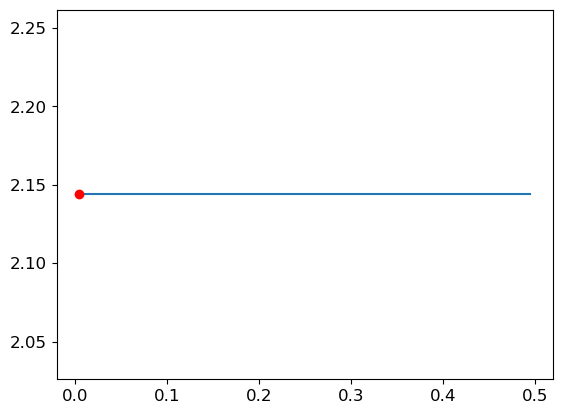

In [59]:
# find min dev loss for smooth parameter
#smooth_star = min(loss)
#smooth_star_ndex = [i]
# max_len_word = max(len(w) for w in words)
# print("num words:", len(words), "min length word:", min_len_word, "max length word:", max_len_word)
# shortest_names = [w for w in words if len(w) <= min_len_word]
# longest_names = [w for w in words if len(w) >= max_len_word]
# https://stackoverflow.com/questions/2474015/getting-the-index-of-the-returned-max-or-min-item-using-max-min-on-a-list
import numpy as np
index_min = np.argmin(loss)
index_min
best_smoother = smooth[index_min]
best_smoother

import matplotlib.pyplot as plt
plt.plot(smooth, loss)
# https://stackoverflow.com/questions/44505762/how-to-plot-additional-points-on-the-top-of-scatter-plot
plt.plot(best_smoother, loss[index_min], "or")

# from the plot the loss is higher closer to 0. it rapidly decreases to a minimum at 0.16 and the starts to increase.


## Multilayer Perceptron

One way to have our model have a lower loss and generate better examples is to increase the context length i.e. the number of letters it uses to predict the next character. For the N-Gram model, the counts matrix grows exponentially. Our bigram with one character of context had 27 possibilities, but a trigram with two characters of context would have 27 * 27 and 3 characters of context would have 27 * 27 * 27 etc.

In our MLP, we will use embeddings to represent characters in a vector space. Initially, these embeddings will be randomly distributed throughout the vector space. During the course of training, the parameters of the embeddings are updated so that "similar" characters move near each other in space and different characters will move elsewhere in the space. If this were applied to words for example, the word "the" and "a" might fall near each other as they can be substitutes for each other likewise "cat" and "dog" may move near each other in space. The embeddings allow the model to generalize better.

The diagram below is the first figure from [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). It shows what we will be building. Note the lookup table C. This is the embedding matrix that we will train to move similar characters near each other. There is a hidden nonlinear tanh layer that is used to squash the inputs between 0 and 1. The final softmax layer normalizes the output of the tanh layer into a proability distribution for predicting the next character.

### Multilayer Perceptron Diagram from [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

![Multilayer Perceptron](MLPFigure1.png)

In the code below, we will start by building our Train, Dev and Test sets. Example X to Y are shown. These example character contexts (X) to next character mappings (Y) are converted to integers that we will use to look up vectors in our embedding matrix. Note that each word contains multiple input and output pairs.

In [17]:
context_size = 3

print("Example inputs and outputs built from words in our data.")
Xtr, Ytr = build_dataset(words_tr, context_size, verbose=True) # training set used to update model parameters
Xdev, Ydev = build_dataset(words_dev, context_size) # development or validation set used to tune hyper parameters like embedding size or hidden layer size
Xte, Yte = build_dataset(words_te, context_size) # test set used once or sparingly. report the performance of the model based on this set.

Example inputs and outputs built from words in our data.
rachyl
input ---> output
... ---> r
..r ---> a
.ra ---> c
rac ---> h
ach ---> y
chy ---> l
hyl ---> .
kaashi
input ---> output
... ---> k
..k ---> a
.ka ---> a
kaa ---> s
aas ---> h
ash ---> i
shi ---> .


We will now write a neural network that takes the Xs and predicts the Ys. As in the paper, we will start by creating the embedding lookup C.

We have 27 characters that we are going to embed in a lower dimensional space. The paper has about 17000 words that they embed into a space as small as 30 dimensions.

We have 27 characters that we start by embedding into 2 dimensional space. We will see later that this is nice, because we can still make a plot of it. This allows us to develop intuition by visualizing the embedding space before we go into higher dimensions.

The lookup table C will start as normally distributed random numbers. There are 27 characters with a vector of length 2 for each, which will give us a 27 X 2 matrix. So instead of using the numbers directly, we use them to look up a vector of numbers that we use to represent the characters. Through training this vector will move around in space to group similar characters together. Similar in that you can think of them as almost substitutes for each other.

You may have encountered one-hot encoding vectors. They are an alternate way to do a matrix lookup. We would start with vector of length 27 with 0s in every position except for a 1 in the row where we want to index. For example if we wanted to select the fifth row of the embedding matrix, the one would be in the fifth position. Multiplying the embedding matrix by this vector would pluck out the fifth row. This is identical to indexing, because the way the matrix multiplication works everything but the fifth row will be masked out (multiplied by 0).

We can either index directly into an embedding lookup table or can create one hot encoding vectors representations that act as linear neurons with weight Matrix C that take as input the one encoding vectors and the first layer embeds them.

We will use the lookup, because it is faster and arguably more intuitive.

At a high level, the neural network can be represented in the image below from [fastbook](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb). We have a model that is our Neural Network. It takes inputs which are the character context. It has weights that are represented in the embedding matrix, weights in hidden tanh layer with its bias and output weights with its bias.

### High Level Training of a Neural Network

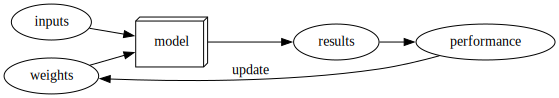

In [18]:
#hide_input
#caption Training a machine learning model
#id training_loop
#alt The basic training loop
gv('''ordering=in
model[shape=box3d width=1 height=0.7]
inputs->model->results; weights->model; results->performance
performance->weights[constraint=false label=update]''')


This model outputs its prediction labeled results. We then compute a performance of the model by calculating a loss through computing Cross Entropy on the expected outcome versus the actual outcome. The expected outcome is given by our training data.

Through a mechanism called [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD) after each iteration, we update our weights by a small amount in the direction that decreases the loss.

We won't dive too deeply into Stochastic Gradient Descent here that can be done in another post. But the basic concept is that with the use of derivatives and the chain rule from Calculus, we nudge the model weights in a direction that improves the performance of our model.

The paper uses Stochastic Gradient Ascent, which seeks to Maximize the Performance Metric. We do the negative, but equal optimization, which is to minimize a loss through Stochastic Gradient Descent. The equation is below. The Learning Rate controls how much we nudge the weights after each iteration.

### Stochastic Gradient Ascent equation from [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
![Stochastic Gradient Ascent](StochasticGradientAscent.png)

In [19]:
#-----------------------------------------------------
hidden_layer_size = 100 #100 # scale up to 300
embedding_size = 2 #10 # increase embedding size to 10 ie. put charaters in 10 dimensional space
#context_size = 3 # put this up, also block size

g = torch.Generator().manual_seed(generator_seed) # for reproducibility
C = torch.randn((27, embedding_size), generator=g) # embedding lookup table
C_init = C.clone()
W1 = torch.randn((embedding_size * context_size, hidden_layer_size), generator=g) # input to the hidden layer
b1 = torch.randn(hidden_layer_size, generator=g) # bias of input to hidden layer
W2 = torch.randn((hidden_layer_size, 27), generator=g) # input to output
b2 = torch.randn(27, generator=g) # bias to input of output
parameters = [C, W1, b1, W2, b2]

print("Total number of parameters")
sum(p.nelement() for p in parameters) # number of parameters in total

Total number of parameters


3481

This first model has 3481 parameters. Compare that with current LLMs with Billions of parameters. The number of parameters is all the numbers in the embedding matrix plus the hidden weights plus the hidden weights bias plus the output weights plus the output weights bias.

We will now create our training loop below. The requires_grad is set to true for all the parameters. This tells Pytorch to keep track of the influence of a parameter on the loss.

The training loop itself consists of a forward pass step to arrive at a next character prediction, back propagation step to compute all the gradients (think partial derivatives with chain rule of all the parameters to find each parameters influence on the loss) and then an update step where we nudge all the parameters in the direction to decrease the loss.

In [20]:
# tell torch to keep track of gradients
for p in parameters:
    p.requires_grad = True

In [21]:
lossi = []
stepi = []

for i in range(400000):

    # minibatch construct
    batch_size = 32 #64 #
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2) , Has effect of replacing each value in X with corresponding embedding
    # hidden layer
    h = torch.tanh(emb.view(-1, embedding_size * context_size) @ W1 + b1)
    # log counts?
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # calculate negative log likelihood
    #print(loss.item())

    # backward pass
    # reset gradients to 0 is the same as setting to None in PyTorch
    for p in parameters:
        p.grad = None
    loss.backward() # calculate the chain rule of derivatives

    # update
    #lr = 0.1 #.01 #.05 #0.1 # decrease learning rate after 60000 in this case
    
    #lr = 0.1 if i < 100000 else 0.01 #.05 #0.1 # decrease learning rate after 60000 in this case
    lr = 0.2 * ((400000-i)/400000.0)
    
    for p in parameters:
        # change parameter by negative of learning rate 0.1 * loss wrt parameter gradient
        # to decrease the loss
        p.data += -lr * p.grad # how to determine this learning rate

    # track stats
    #lri.append(lre[i]) # get the exponent
    stepi.append(i)
    lossi.append(loss.item())

Next we compute the loss on the Training and Dev Sets. If the training loss starts to get much better that the Dev loss, this can be a sign we are starting to overfit to the training data. We are still good in this case. Note we are already doing significantly better than the bigram model.

In [22]:
# compute loss on training set
emb = C[Xtr] 
# hidden layer
h = torch.tanh(emb.view(-1, embedding_size * context_size) @ W1 + b1)
# log counts?
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr) # equivalent to negative log likelihood. use this because faster better in pytorch.
print("training loss",loss.item())

training loss 2.2265753746032715


In [23]:
# compute loss on dev set
emb = C[Xdev] 
# hidden layer
h = torch.tanh(emb.view(-1, embedding_size * context_size) @ W1 + b1)
# log counts?
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev) # equivalent to negative log likelihood
print("dev loss", loss.item())

dev loss 2.2286863327026367


As part of the training loop, we kept track of the iteration and the current loss. There are two things to note in the plot below. One is the hockey stick shape of the plot. There is a high loss initially, but it rapidly comes down. This is a sign we are not initializing our Network efficiently. The model is initially confidently wrong. It is performing worse than random chance. A better initialization method is beyond the scope of the current blog and may be explored more in future posts. In this case, it is not a problem, but poor network initialization can lead to problems for large networks.

The second thing to note is the caterpillar-like shape of the plot. This is because we are using a sample of the data called a batch in each iteration. It turns out to be better, cheaper and faster to use a batch versus the entire dataset in each iteration. It is good enough to have an approximate direction of the gradient, but this causes the gradient to thrash around.

The batch size is one of the hyperparameters we can tune. There are others like the size of the tanh layer, embedding size and learning rate. In practice we would change the values of these hyperparameters in a loop and check how it does on improving the Dev loss and pick the best one.

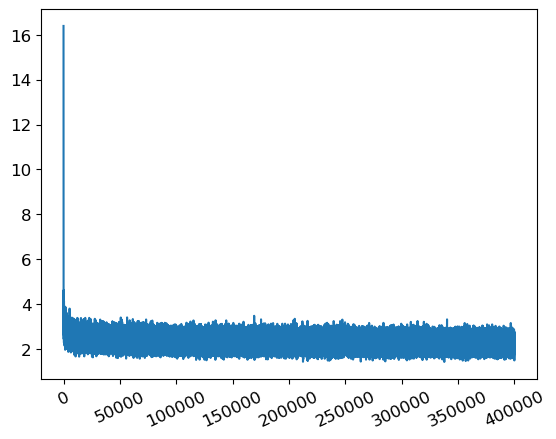

In [25]:
plt.plot(stepi, lossi)
#https://www.geeksforgeeks.org/how-to-rotate-x-axis-tick-label-text-in-matplotlib/
plt.xticks(rotation = 25)
plt.show()
# note the hockey stick shape. this means we could do better initializing our model
# waste beginning iterations slowly training. initially confidentally wrong. worse than chance

Since our embedding vectors are currently in two dimensional space, we can plot them to visually see what the network is doing to the embeddings. Earlier, the initial value of the embedding matrix was saved. We can compare them now.

Below is the embedding matrix C as it was initialized randomly with a normal distribution. There are not any obvious patterns.

### Plot of randomized two dimensional Embeddings

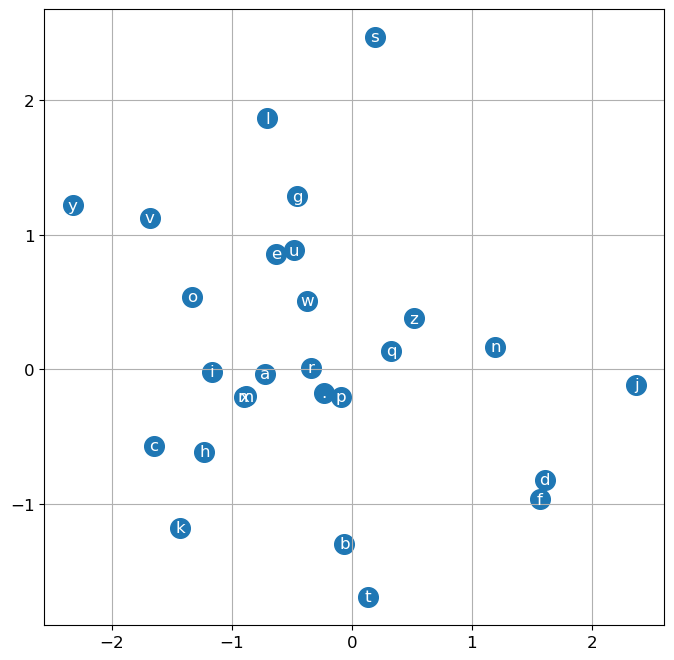

In [26]:
plt.figure(figsize=(8,8))
plt.scatter(C_init[:,0].data, C_init[:,1].data, s=200)
for i in range(C_init.shape[0]):
    plt.text(C_init[i,0].item(), C_init[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

Below is a plot of the embedding matrix after training. Note how the vowels are clustered near each other. The neural network thinks they are very similar i.e. they are almost substitutes for each other.

### Plot of trained two dimensional Embeddings

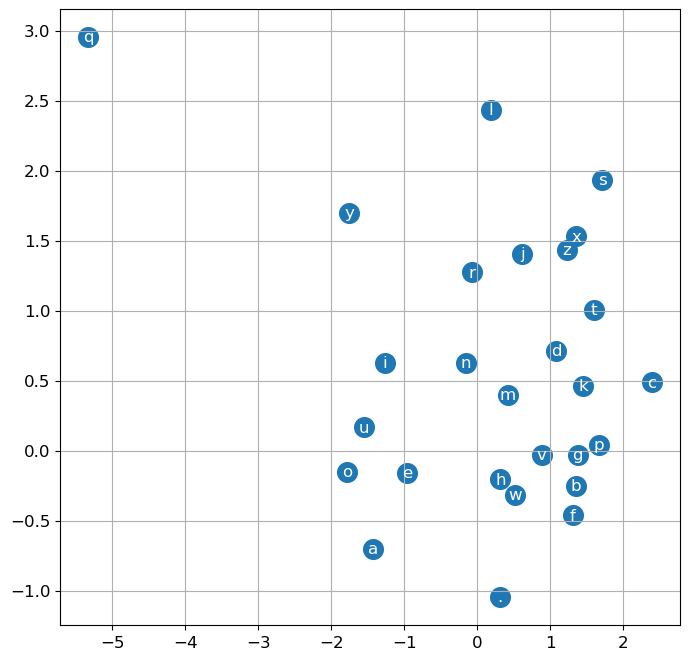

In [27]:
# bottle neck now may be size of embeddings
# we may be cramming way too much stuff into two dimensions
# but two dimensions is nice because you can visuzalie it
# before changing the embedding size we will plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

Now let's try sampling from the model again to see what names it produces. It is looking better to me.

In [28]:
# sample from the model
g = torch.Generator().manual_seed(generator_seed)
for _ in range(20):
    out = []
    context = [0] * context_size #block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

# starting to look more name like

laia.
jana.
voulia.
zain.
adaya.
kinlyno.
trous.
keel.
kark.
alay.
nalluck.
lashivel.
vliyaher.
josu.
madmaireya.
dimyan.
safoltun.
ochlyr.
saniliaa.
avurudenesikelene.


Next we scale up the neural network by increasing the hidden layer size, embedding size, batch size and the size of the context. This is hyperparameter tuning. At this point, we are just trying out things and seeing if we get improvements, but again we could run many experiments changing the hidden layer size for example and find the one with the best loss.

We start by recreating the dataset. Note that the input now consists of five characters of context.

In [29]:
# build the dataset with context length.
print("Example inputs and outputs built from words in our data.")
context_size = 5 #4 # 3


# build bigram dataset. note second dimension of x is 1. this is the context length (block_size)
Xtr, Ytr = build_dataset(words_tr, context_size, verbose=True) # training set used to update model parameters
Xdev, Ydev = build_dataset(words_dev, context_size) # development or validation set used to tune hyper parameters like embedding size or hidden layer size
Xte, Yte = build_dataset(words_te, context_size) # test set used once or sparingly. report the performance of the model based on this set.

Example inputs and outputs built from words in our data.
rachyl
input ---> output
..... ---> r
....r ---> a
...ra ---> c
..rac ---> h
.rach ---> y
rachy ---> l
achyl ---> .
kaashi
input ---> output
..... ---> k
....k ---> a
...ka ---> a
..kaa ---> s
.kaas ---> h
kaash ---> i
aashi ---> .


In [30]:
#-----------------------------------------------------

# run experiments with parameters to find best loss

hidden_layer_size = 300 #100 # scale up to 300
embedding_size = 10 #10 # increase embedding size to 10 ie. put charaters in 10 dimensional space
#context_size = 3 # put this up, also block size

g = torch.Generator().manual_seed(generator_seed) # for reproducibility
C = torch.randn((27, embedding_size), generator=g) # embedding lookup table
W1 = torch.randn((embedding_size * context_size, hidden_layer_size), generator=g) # input to the hidden layer?
b1 = torch.randn(hidden_layer_size, generator=g) # bias of input to hidden layer?
W2 = torch.randn((hidden_layer_size, 27), generator=g) # input to output?
b2 = torch.randn(27, generator=g) # bias to input of output
parameters = [C, W1, b1, W2, b2]

print("Total number of parameters")
sum(p.nelement() for p in parameters) # number of parameters in total

Total number of parameters


23697

We have scaled up our model to 23697 parameters.

In [31]:
# tell torch to keep track of gradients
for p in parameters:
    p.requires_grad = True

In [32]:
lossi = []
stepi = []

# training loop


for i in range(400000):

    # minibatch construct
    batch_size = 64 #32
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2) , Has effect of replacing each value in X with corresponding embedding
    # hidden layer
    h = torch.tanh(emb.view(-1, embedding_size * context_size) @ W1 + b1)
    # log counts?
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # calculate negative log likelihood. classification loss function.
    #print(loss.item())

    # backward pass
    # reset gradients to 0 is the same as setting to None in PyTorch
    for p in parameters:
        p.grad = None
    loss.backward() # calculate the chain rule of derivatives

    # update
    #lr = 0.1 #.01 #.05 #0.1 # decrease learning rate after 60000 in this case
    
    #lr = 0.1 if i < 100000 else 0.01 #.05 #0.1 # decrease learning rate after 60000 in this case
    lr = 0.2 * ((400000-i)/400000.0)
    
    for p in parameters:
        # change parameter by negative of learning rate 0.1 * loss wrt parameter gradient? 
        # to decrease the loss
        p.data += -lr * p.grad # how to determine this learning rate

    # track stats
    #lri.append(lre[i]) # get the exponent
    stepi.append(i)
    lossi.append(loss.item())


#print(loss.item()) # only loss for minibatch

In [33]:
# compute loss on training set
emb = C[Xtr] 
# hidden layer
h = torch.tanh(emb.view(-1, embedding_size * context_size) @ W1 + b1)
# log counts
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr) # same as negative log likelihood
print("training loss", loss.item())

training loss 2.131795883178711


In [34]:
# compute loss on dev set
emb = C[Xdev] 
# hidden layer
h = torch.tanh(emb.view(-1, embedding_size * context_size) @ W1 + b1)
# log counts?
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev) # same as negative log likelihood
print("dev loss", loss.item())
# batch size 32, loss = 2.2296578884124756
# batch size 64, loss = 2.1915667057037354
#2.1834094524383545
#2.178189516067505
#2.1498525142669678

# do evaluation on test set at the end

# dev and test set is diverging. starting to overtrain

dev loss 2.1600215435028076


Note the training loss is getting better than the dev loss. We are starting to overfit, so we will stop here. Let's calculate the loss on the test set that we would use to report the performance of our model.

In [35]:
# compute loss on test set
emb = C[Xte] 
# hidden layer
h = torch.tanh(emb.view(-1, embedding_size * context_size) @ W1 + b1)
# log counts?
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yte) # calculate negative log likelihood?
print("test loss", loss.item())
# batch size 32, loss = 2.2296578884124756
# batch size 64, loss = 2.1915667057037354
#2.1834094524383545
#2.178189516067505
#2.1498525142669678

# do evaluation on test set at the end

test loss 2.158057928085327


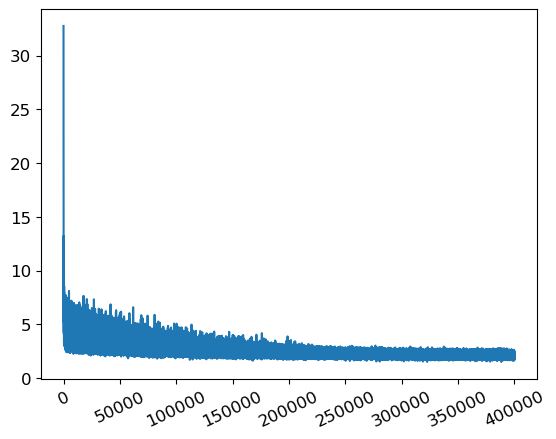

In [36]:
plt.plot(stepi, lossi)
plt.xticks(rotation = 25)
plt.show()
# note the hockey stick shape. this means we could do better initializing our model
# waste beginning iterations slowly training. initially confidentally wrong. worse than chance

Again, let's generate samples from our model to see the model in action.

In [37]:
# sample from the model

g = torch.Generator().manual_seed(generator_seed + 0)
for _ in range(20):
    out = []
    context = [0] * context_size #block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

maia.
janav.
kulia.
zatelana.
ajkinly.
ogtisha.
keeli.
vranaya.
dedushra.
lastha.
chally.
ierea.
juhayda.
gusyem.
imhan.
safolaun.
mikly.
sechilina.
avuruddae.
jhelene.


## Conclusion

We walked through an early language modeling technique with the bigram and then went on to build a language model that ushered in the beginning of modern language modeling techniques. Along the way, we employed some best pratices in Data Science projects by splitting our data to get an accurate gauge on the performance of our model on unseen data. We also did some manual hyperparameter tuning, which could be improved through automation.

This post was heavily influenced by the first three lessons in [Neural Networks: Zero to Hero](https://karpathy.ai/zero-to-hero.html). That is a good place to continue this journey, but it can be somewhat challenging for beginners. It is worth checking out [Practical Deep Learning for Coders](https://course.fast.ai/) from FastAI to start out. The related discord for Fast AI is a great community to connect with to progress in Deep Learning.

## References

1. [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

2. [Neural Networks: Zero to Hero](https://karpathy.ai/zero-to-hero.html)

3. [Fastbook](https://github.com/fastai/fastbook)

4. [Revisiting Simple Neural Probabilistic Language Models](https://paperswithcode.com/paper/revisiting-simple-neural-probabilistic)